In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(".".join(words)))); len(chars)
stoi = {c:i for i,c in enumerate(chars)}
itos = {c:i for i,c in stoi.items()}
itos[0], stoi["."]

('.', 0)

In [3]:
# Simple bigram model created using counts
N = torch.zeros(27, 27, dtype=torch.int32)
for w in words:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    N[i1,i2] += 1

(-0.5, 26.5, 26.5, -0.5)

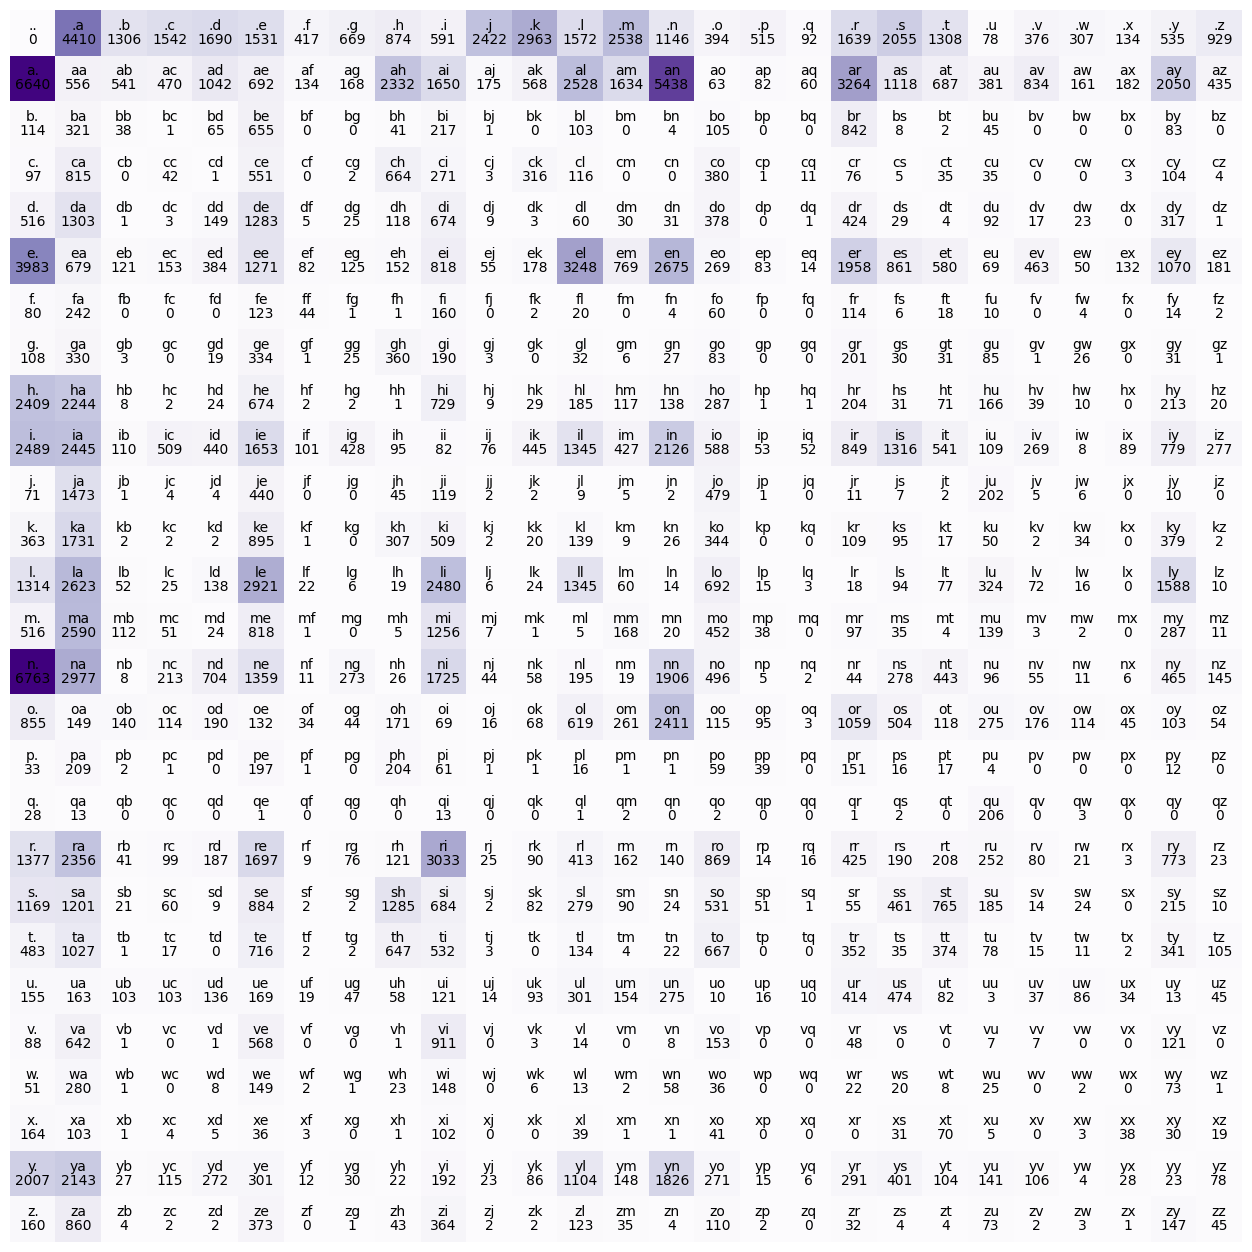

In [4]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Purples')
for i in range(N.shape[0]):
  for j in range(N.shape[1]):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='black')
    plt.text(j, i, N[i,j].item(), ha='center', va='top', color='black')
plt.axis('off')

In [5]:
p = N[0].float()
p = p/p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [6]:
g = torch.Generator().manual_seed(234124)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

'k'

In [7]:
P = (N+1).float() # +1 for model smoothening
P /= P.sum(1, keepdim=True)

In [8]:
for i in range(4):
  out = []
  idx = 0
  while True:
    p = P[idx]
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[idx])
    if idx == 0: break
  print("".join(out))

fon.
s.
fahe.
a.


In [9]:
# loss function
n = 0
ll = 0.

for w in words:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    prob = P[i1, i2]
    lprob = torch.log(prob)
    ll += lprob
    n += 1

log_likelihood = (ll/n).item()
print(f"{ll.item():.4f}")
print(f"{log_likelihood=:.4f}")
print(f"{-log_likelihood:.4f}")

-559951.5625
log_likelihood=-2.4544
2.4544


### training a bigram model using neural network

In [10]:
# Creating XS and YS
xs,ys = [],[]

for w in words:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    print(c1, c2)
    xs.append(i1)
    ys.append(i2)
  break # lets see for the first word "emma"

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

. e
e m
m m
m a
a .
tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


In [11]:
# init weights
g = torch.Generator().manual_seed(234124)
W = torch.randn(27, 27, generator=g, requires_grad=True)

In [12]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc@W
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
loss = -probs[range(5), ys].log().mean()
print(loss.item())

#backward pass
loss.backward()

# step
W.data -= W.grad.data * 0.01

4.339427947998047


In [13]:
xs, ys = [], []
for w in words:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    xs.append(i1)
    ys.append(i2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

g = torch.Generator().manual_seed(234124)
W = torch.randn(27, 27, generator=g, requires_grad=True)

nums = xs.shape[0]; nums

228146

In [14]:
for k in range(100):
  W.grad = None
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc@W
  counts = logits.exp()
  probs = counts/counts.sum(1, keepdim=True)
  loss = -probs[range(nums), ys].log().mean() + 0.01*(W**2).mean()
  if k%10==0: print(f"{loss.item():.4f}")

  loss.backward()
  # W.grad += wd * 2 * W # weight decay
  W.data -= W.grad.data * 50

3.7515
2.6843
2.5811
2.5417
2.5220
2.5107
2.5035
2.4987
2.4952
2.4926


Visualizing the weight matrix trained with neural net

(-0.5, 26.5, 26.5, -0.5)

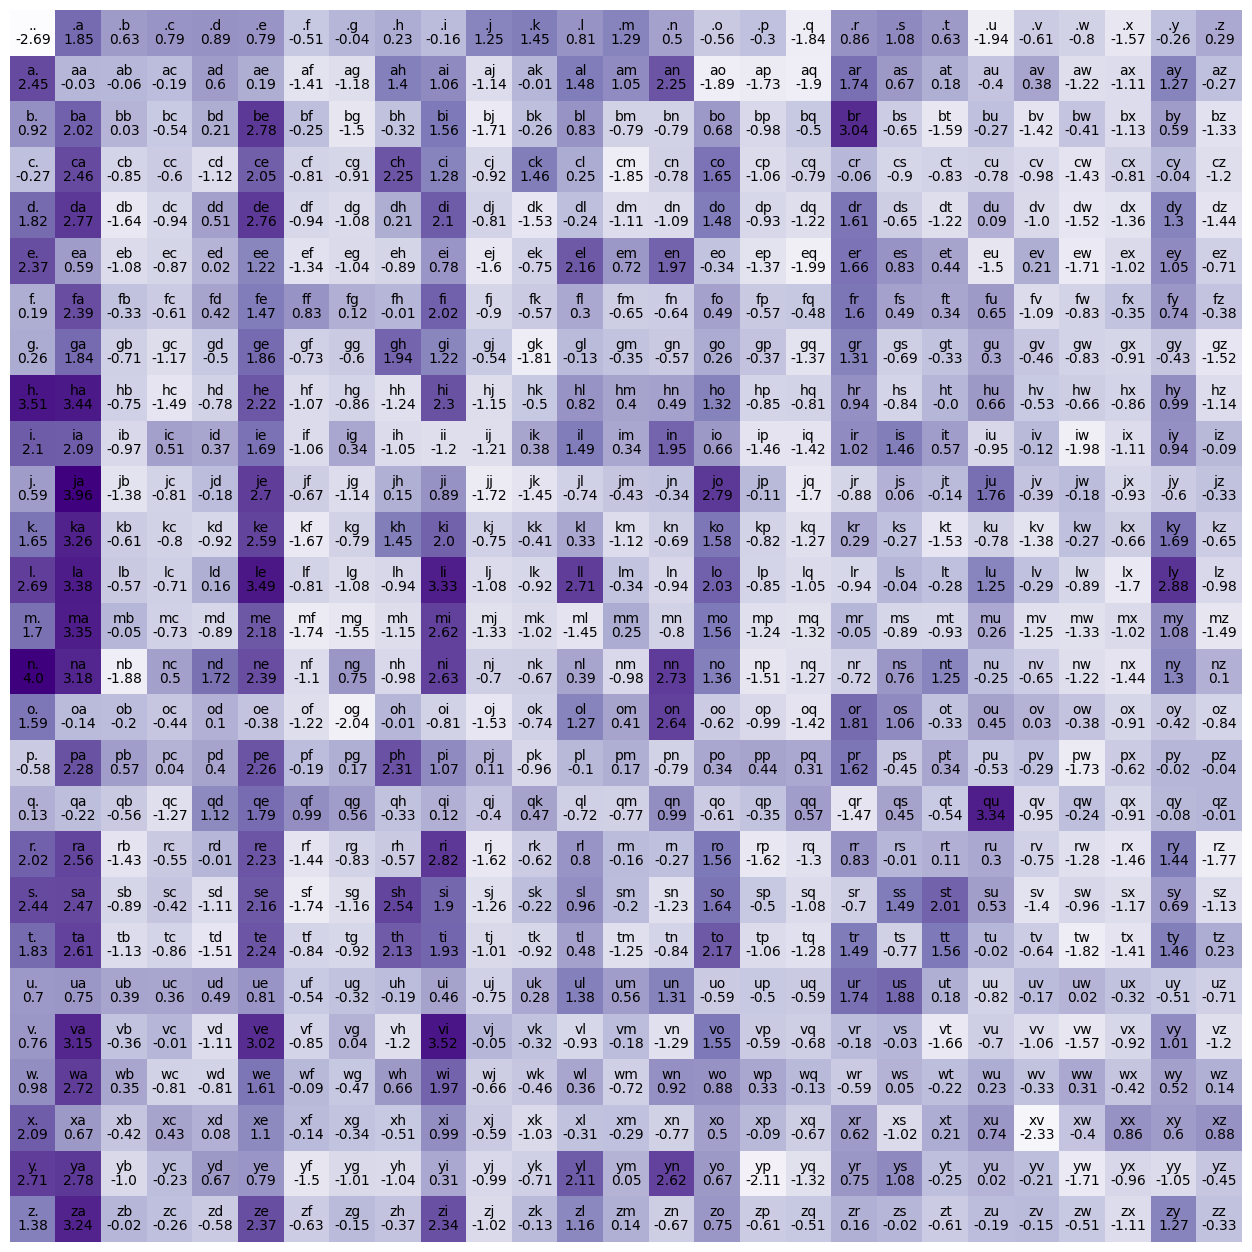

In [15]:
plt.figure(figsize=(16,16))
plt.imshow(W.data, cmap='Purples')
for i in range(W.shape[0]):
  for j in range(W.shape[1]):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='black')
    plt.text(j, i, round(W[i,j].item(), 2), ha='center', va='top', color='black')
plt.axis('off')

Sampling

In [16]:
for i in range(4):
  out = []
  idx = 0
  while True:
    xenc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
    logits = xenc@W
    counts = logits.exp()
    p = counts/counts.sum(1, keepdim=True)
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[idx])
    if idx == 0: break
  print("".join(out))

jagahan.
jema.
yadalith.
rana.


## BONUS: Trigram model implementation

In [17]:
g = torch.Generator().manual_seed(234124)
loss_func = torch.nn.CrossEntropyLoss()

xs,ys = [],[]
for w in words:
  w = ['.'] + list(w) + ['.']
  for i in range(len(w)-2):
    x = [stoi[k] for k in w[i:i+2]]
    y = stoi[w[i+2]]
    xs.append(x)
    ys.append(y)

xs, ys = torch.tensor(xs), torch.tensor(ys)
list(zip(xs[:2], ys[:2]))

[(tensor([0, 5]), tensor(13)), (tensor([ 5, 13]), tensor(13))]

In [18]:
W = torch.randn(54, 27, generator=g, requires_grad=True)

In [23]:
bs = 250

for k in range(200):
  # mini batch
  idx = torch.randint(0, len(xs), (bs,))
  xbs = xs[idx]
  ybs = ys[idx]

  # forward
  xenc = F.one_hot(xbs, num_classes=27).view(-1, 54).float()
  logits = xenc@W
  loss = loss_func(logits, ybs) # + 0.01 * (W**2).mean() # Weight decay

  # backward
  W.grad = None
  loss.backward()
  lr = 0.1 if k<50000 else 0.01
  W.data -= W.grad.data * lr

  # track
  if k%100==0: print(f"{k}: loss: {loss:.4f}")

0: loss: 2.2237
100: loss: 2.2282


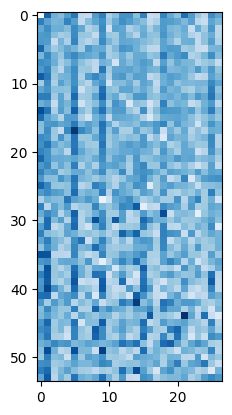

In [24]:
plt.imshow(W.tolist(), cmap='Blues')

Trigram Sampling

In [26]:
# something is amiss

# for _ in range(4):
#   with torch.no_grad():
#     out = []
#     padding = [0]*2
#     while True:
#       xenc = F.one_hot(torch.tensor(padding), num_classes=27).view(-1).float()
#       preds = (xenc@W).softmax(-1)
#       idx = torch.multinomial(preds,num_samples=1, replacement=True).item()
#       padding = padding[:1] + [idx]
#       out.append(itos[idx])
#       if idx == 0: break
#     print("".join(out))

In [27]:
# Creating Train, Valid and Test dataset
tr, va, te = (0.8, 0.1, 0.1) #80% train, 10% valid, 10% test

nums = len(words)
tr = int(tr * nums)
va = int(va * nums)
te = nums - tr - va

train = words[:tr]
val = words[tr:tr + va]
test = words[tr + va:]


# Creating XS and YS
xs,ys = [],[]
for w in train:
  w = ['.'] + list(w) + ['.']
  for c1, c2 in zip(w, w[1:]):
    i1, i2 = stoi[c1], stoi[c2]
    xs.append(i1)
    ys.append(i2)

xtr = torch.tensor(xs)
ytr = torch.tensor(ys)

In [28]:
W = torch.randn(27, 27, requires_grad=True)
loss_func = torch.nn.CrossEntropyLoss()

In [31]:
lr = 0.5
WD = 0.01
i = 0
ud = [] #update data ratio
bs = 32

for i in range(2000):
  #mini batch
  idx = torch.randint(0, len(xtr), (bs,))
  xbs = xtr[idx]
  ybs = ytr[idx]

  # forward
  xenc = W[xbs]
  logits = xenc@W
  loss = loss_func(logits, ybs)

  # backward
  W.grad = None
  loss.backward()
  W.data -= W.grad * lr

  # track
  print(f"{i} | loss: {loss:.4f}")
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in [W]])

0 | loss: 2.6918
1 | loss: 2.4223
2 | loss: 2.4481
3 | loss: 2.2673
4 | loss: 2.2266
5 | loss: 2.3092
6 | loss: 2.6554
7 | loss: 2.1185
8 | loss: 2.5145
9 | loss: 2.5660
10 | loss: 2.5262
11 | loss: 2.5617
12 | loss: 2.3829
13 | loss: 2.3625
14 | loss: 2.5350
15 | loss: 2.4386
16 | loss: 2.5964
17 | loss: 2.3309
18 | loss: 2.4490
19 | loss: 2.4960
20 | loss: 2.6756
21 | loss: 2.4029
22 | loss: 2.5738
23 | loss: 2.5971
24 | loss: 2.4979
25 | loss: 2.2430
26 | loss: 2.4945
27 | loss: 2.5329
28 | loss: 2.4300
29 | loss: 2.6015
30 | loss: 2.1987
31 | loss: 2.6850
32 | loss: 2.6146
33 | loss: 2.4232
34 | loss: 2.5137
35 | loss: 2.6696
36 | loss: 2.3820
37 | loss: 2.3481
38 | loss: 2.4267
39 | loss: 2.4035
40 | loss: 2.1491
41 | loss: 2.2936
42 | loss: 2.4843
43 | loss: 2.3016
44 | loss: 2.5708
45 | loss: 2.6057
46 | loss: 2.2809
47 | loss: 2.3827
48 | loss: 2.0734
49 | loss: 2.3438
50 | loss: 2.5232
51 | loss: 2.2615
52 | loss: 2.4165
53 | loss: 2.7055
54 | loss: 2.3077
55 | loss: 2.4449
56

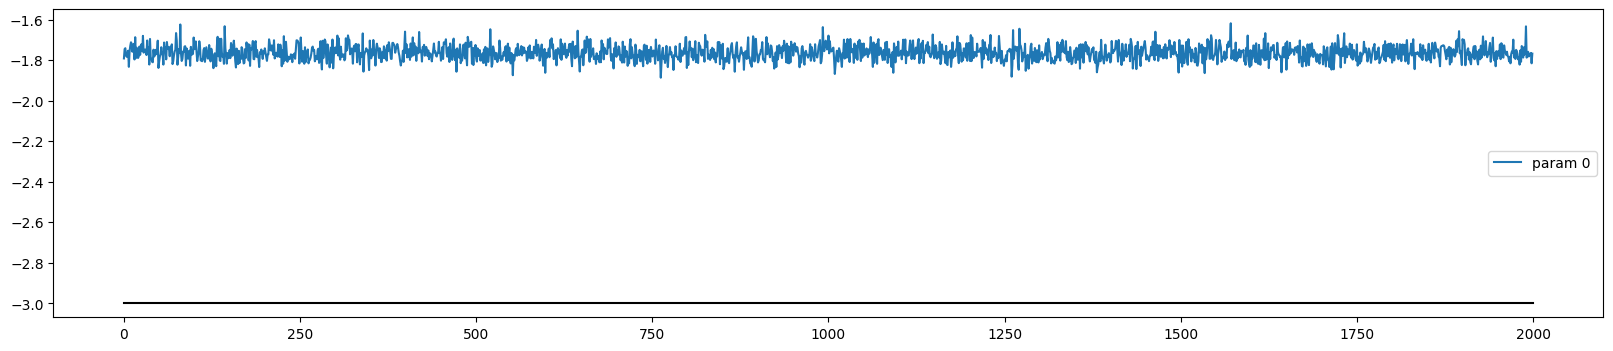

In [32]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate([W]):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [34]:
for _ in range(10):
  out = []
  padding = [0]
  while True:
    xenc = W[torch.tensor(padding)]
    logits = torch.softmax(xenc@W, 1)
    idx = torch.multinomial(logits, num_samples=1, replacement=True).item()
    padding = padding[1:] + [idx]
    out.append(itos[idx])
    if idx == 0: break
  print("".join(out))

e.
e.
lyna.
an.
rarinn.
sona.
mchaisxeynan.
obayeerke.
lelutabe.
ma.
